# Univariate Analysis of S&P/Case-Shiller U.S. National Home Price Index
#### Micheal Lucky (smgmol56@gmail.com) 
#### Yonas Menghis Berhe (yonix500@gmail.com)
#### Boluwatife Adeyeye (adeyeyebolu027@gmail.com)
#### Muhammed Jamiu Saka (sakasim_jay@yahoo.com)
#### Sola-Aremu Oluwapelumi (solaaremu.pelumi@gmail.com)

In [1]:
# importing the necessary packages
library(tidyverse)
library(stats)
library(readxl)
library(tseries)
library(forecast)
library(lmtest)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.4.1     v dplyr   0.7.4
v tidyr   0.7.2     v stringr 1.2.0
v readr   1.1.1     v forcats 0.2.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter()  masks stats::filter()
x purrr::flatten() masks jsonlite::flatten()
x dplyr::lag()     masks stats::lag()
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



In [4]:
# importing data, - change directory when using the code
# data used is a yearly percentage change
CSUSHPISA<-read_excel("C:/Users/Pelumi/Downloads/CSUSHPISA_P.xls", 
                      sheet = "FRED Graph",col_names = T, col_types = c("date", "numeric"), skip = 10)

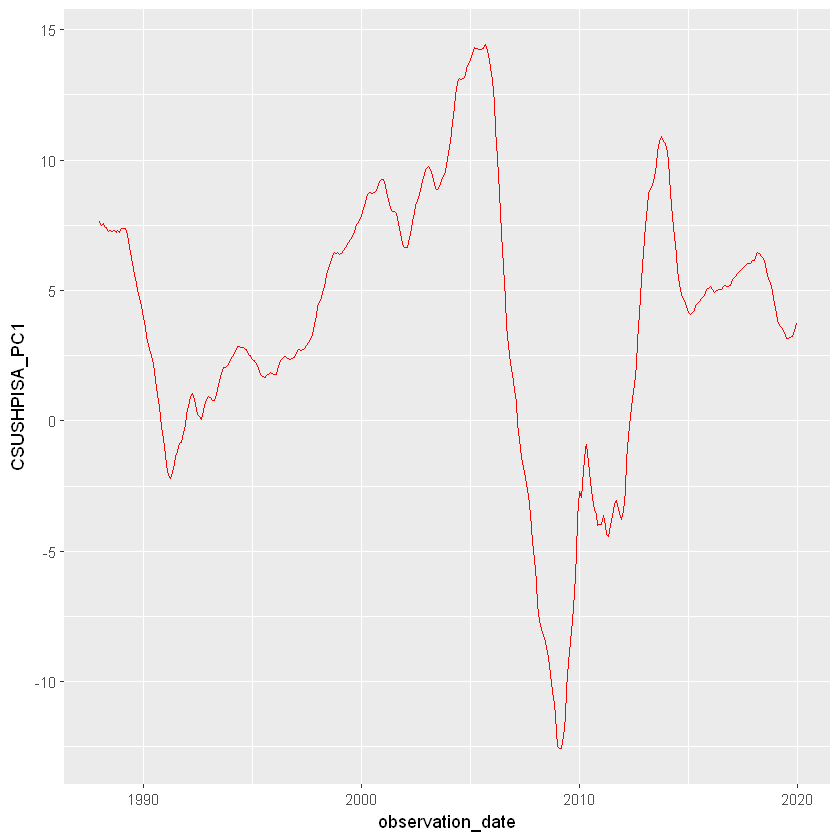

In [6]:
# visual inspection on the type of times series
ggplot(data = CSUSHPISA) + geom_line(mapping = aes(x = observation_date, y = CSUSHPISA_PC1), color = "red")


#### This series shows no mean reversion indicating non-stationarity

In [7]:
# converting data to a time series object
HPI_pct_chg <- ts(CSUSHPISA$CSUSHPISA_PC1, start=1987, frequency=12)

## Augmented Dickey-Fuller Test for sample data from 1987 to 2018

In [8]:
# Augmented Dickey-Fuller Test for sample data from 1987 to 2018
adf.test(window(HPI_pct_chg,start=1987,end = 2018)) 


	Augmented Dickey-Fuller Test

data:  window(HPI_pct_chg, start = 1987, end = 2018)
Dickey-Fuller = -3.0277, Lag order = 7, p-value = 0.1432
alternative hypothesis: stationary


#### According to the results we cannot reject the null hyphothesis(p-value = 0.1432) that errors are white noise, so the series is non-stionary

## ACF and PACF

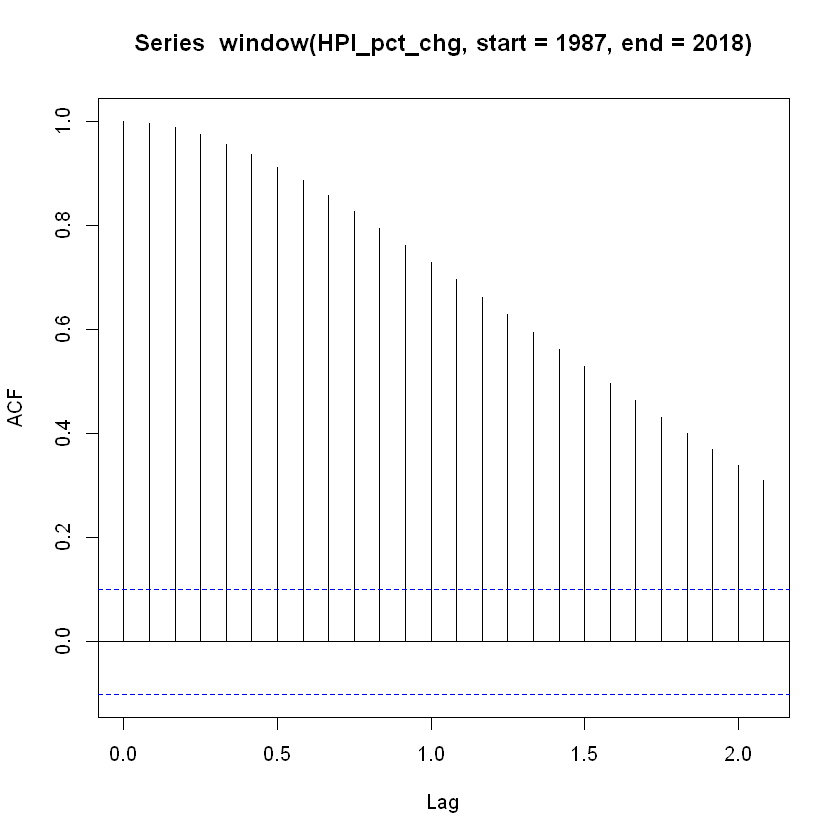

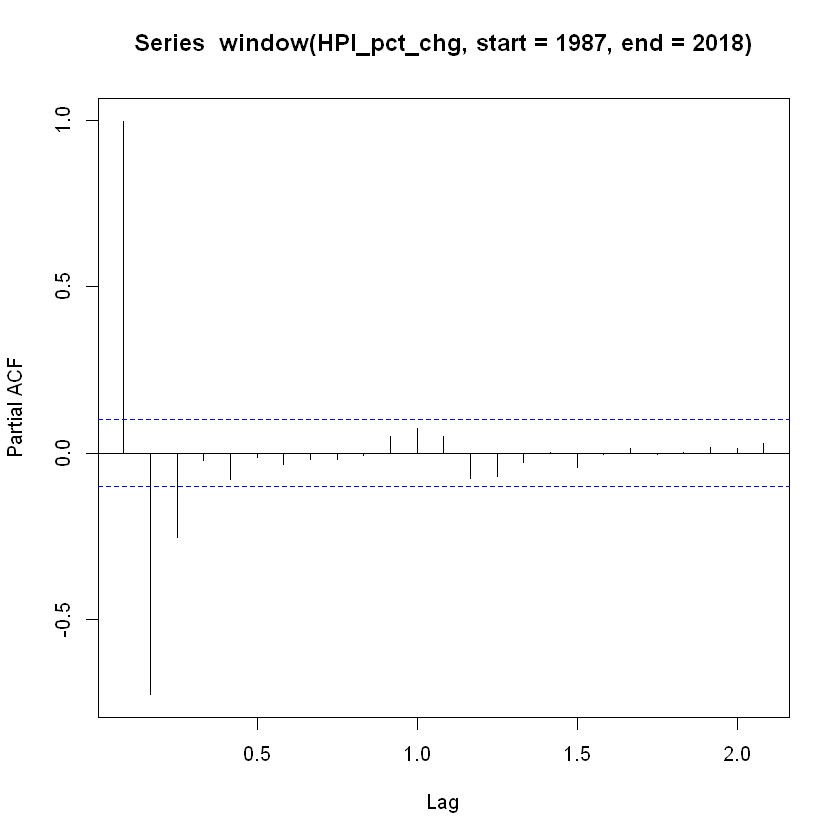

In [9]:
acf(window(HPI_pct_chg,start=1987,end = 2018))
pacf(window(HPI_pct_chg,start=1987,end = 2018))

#### ACF -- auto-correlations are very close to high and slowly fade 
#### PACF -- drops sharly after the zeroth lag and 
#### This shows AR or ARIMA model is more relevant

In [10]:
# taking the first difference and test for stationarity
diff1 = diff(window(HPI_pct_chg,start=1987,end = 2018),diff=1)
adf.test(diff1) 

Warning message in adf.test(diff1):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  diff1
Dickey-Fuller = -4.2225, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


#### Test shows stationarty after first difference is applied

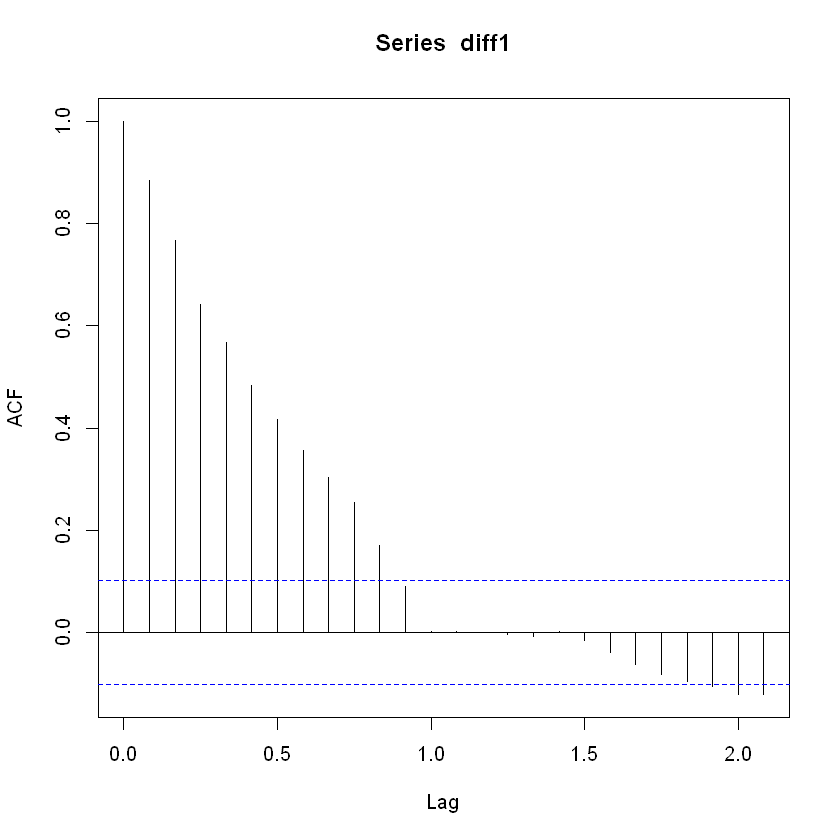

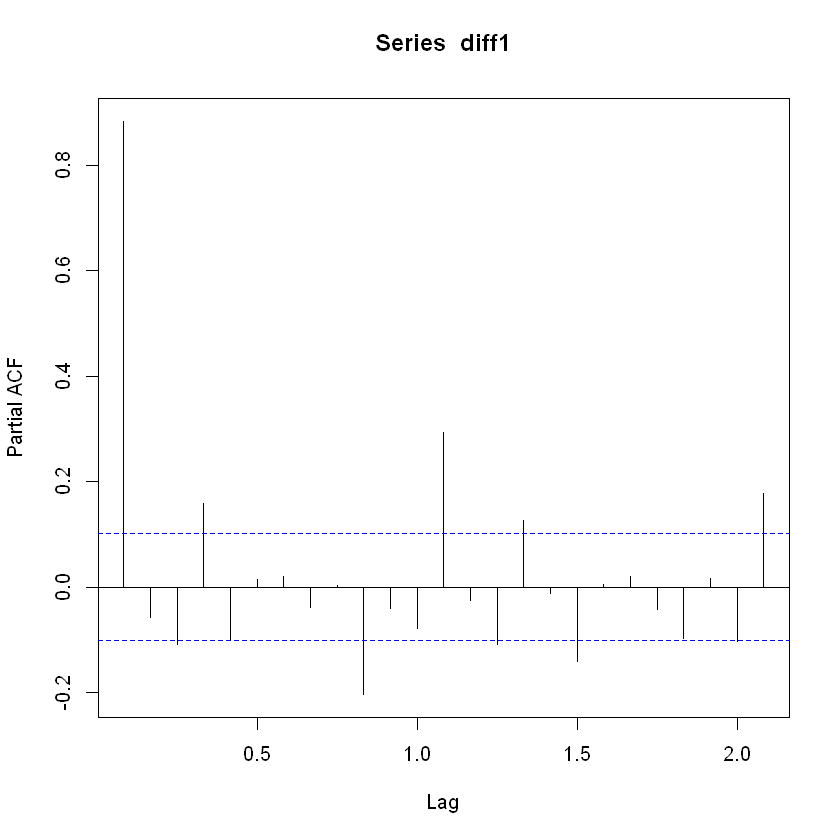

In [11]:
acf(diff1)
pacf(diff1)

#### ACF exponentially decaying after the firs lag and PACF drops sharply after the zeroths lag

## ARIMA model 1 with lag 1, with no differencing and no moving average terms - i.e. an ARIMA(1,0,0) model

In [12]:
ARIMA_1 <- arima(window(HPI_pct_chg,start=1987,end = 2018), order=c(1,0,0), method = "ML")
summary(ARIMA_1)


Call:
arima(x = window(HPI_pct_chg, start = 1987, end = 2018), order = c(1, 0, 0), 
    method = "ML")

Coefficients:
         ar1  intercept
      0.9957     4.9210
s.e.  0.0033     3.4329

sigma^2 estimated as 0.1829:  log likelihood = -214.84,  aic = 435.68

Training set error measures:
                      ME      RMSE       MAE      MPE     MAPE     MASE
Training set -0.01349148 0.4277038 0.3038795 2.786628 15.26345 1.007051
                  ACF1
Training set 0.8824182


#### Coefficients are not statistcally significant at 5% level with AIC 435
#### Huge difference between the coefficinet and the estimate errors

In [13]:
coeftest(ARIMA_1)


z test of coefficients:

          Estimate Std. Error  z value Pr(>|z|)    
ar1       0.995656   0.003334 298.6347   <2e-16 ***
intercept 4.920970   3.432917   1.4335   0.1517    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


#### Most of the coeffcients are insiginificant at 5% level

In [14]:
Box.test(ARIMA_1$residuals, lag = 1)


	Box-Pierce test

data:  ARIMA_1$residuals
X-squared = 290.44, df = 1, p-value < 2.2e-16


#### The test shows that errors are not white noise, so there is serial correlation

## ARIMA model 2 with 1 lags, 1 differencing but no moving average terms --  ARIMA(1,1,0)

In [15]:
ARIMA_2 <- arima(window(HPI_pct_chg,start=1987,end = 2018), order=c(1,1,0), method = "ML")
summary(ARIMA_2) 


Call:
arima(x = window(HPI_pct_chg, start = 1987, end = 2018), order = c(1, 1, 0), 
    method = "ML")

Coefficients:
         ar1
      0.8832
s.e.  0.0239

sigma^2 estimated as 0.03994:  log likelihood = 70.41,  aic = -136.82

Training set error measures:
                       ME      RMSE       MAE      MPE     MAPE      MASE
Training set -0.001778031 0.1995715 0.1298027 1.529716 6.396026 0.4301638
                   ACF1
Training set 0.05206018


#### Some coefficients are statistcally significant with -136.82 AIC
#### Very low difference between the coefficients and the estimated errors

In [16]:
coeftest(ARIMA_2)
Box.test(ARIMA_2$residuals, lag = 1)


z test of coefficients:

    Estimate Std. Error z value  Pr(>|z|)    
ar1 0.883236   0.023937  36.899 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



	Box-Pierce test

data:  ARIMA_2$residuals
X-squared = 1.0109, df = 1, p-value = 0.3147


## ARIMA model2 with 2 lags, with two differencing but no moving average terms - i.e. an ARIMA(1,2,0) model

In [17]:
ARIMA_3 <- arima(window(HPI_pct_chg,start=1987,end = 2018), order=c(1,2,0), method = "ML")
summary(ARIMA_3)


Call:
arima(x = window(HPI_pct_chg, start = 1987, end = 2018), order = c(1, 2, 0), 
    method = "ML")

Coefficients:
          ar1
      -0.0038
s.e.   0.0519

sigma^2 estimated as 0.04244:  log likelihood = 59.67,  aic = -115.34

Training set error measures:
                        ME      RMSE       MAE      MPE     MAPE      MASE
Training set -0.0006668962 0.2054689 0.1353884 1.365645 6.707377 0.4486745
                     ACF1
Training set 1.138544e-05


#### Coefficients are not statistcally significant with AIC -115.34
#### Very low difference between the coefficients and the estimated errors

In [19]:
coeftest(ARIMA_3)
Box.test(ARIMA_3$residuals, lag = 1)


z test of coefficients:

      Estimate Std. Error z value Pr(>|z|)
ar1 -0.0038436  0.0519194  -0.074    0.941



	Box-Pierce test

data:  ARIMA_3$residuals
X-squared = 4.8351e-08, df = 1, p-value = 0.9998


#### Test shows that errors are white noise, so there is no serial correlation

## Forecast the future evolution of Case-Shiller Index

#### Using the ARIMA model 1, since model 2 has;
####      - lowest AIC, 
####      - very low differnce between the estimated and the coeffienct standard errors
####       - white noise residuals
#### This is better model for forcasting with p=1 d=1 q=0   ARIMA(1,1,0)

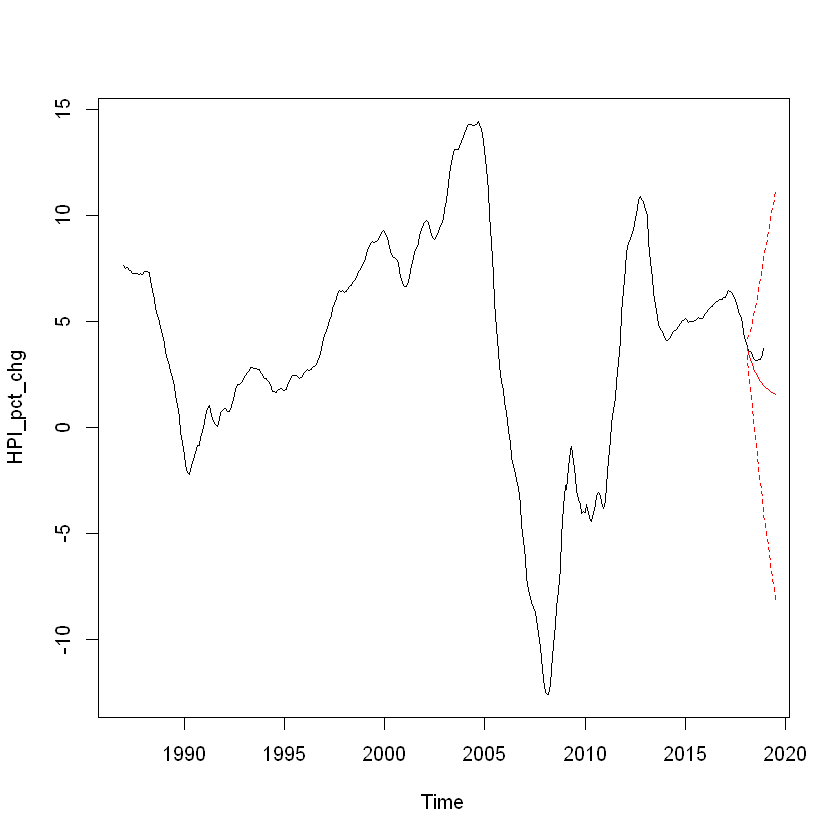

In [20]:
AR_forecast <- predict(ARIMA_2, n.ahead= 18, se.fit=TRUE)
plot.ts(HPI_pct_chg)
lines(AR_forecast$pred,col="red")
lines(AR_forecast$pred + 2*AR_forecast$se,col="red", lty = "dashed")
lines(AR_forecast$pred - 2*AR_forecast$se,col="red", lty = "dashed")